In [20]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

## Seeding

Set the seed of reproductibility so that the random data generated is repeated.
np.random.seed(seed_value)
--> seed_value: the input value used to "seed" the pseudo-random generator algorithm

In [21]:
np.random.seed(1234)

## Load Dataset

Load the classical Iris dataset from scikit learn library.

In [22]:
from sklearn import datasets
dataset = datasets.load_iris()
# print(dataset.DESCR)

## Train and Test Datasets
Create an input matrix N x D and an output vector y = {1, ..., C}^N.
We will use only sepal length and sepal width since they have high correlation with the class label.

Then, we randomly split the data into train and test set

In [23]:
x, y = dataset['data'][:,:2], dataset['target']
# number of instances and number of dimensions
(N,D) = x.shape
# number of classes
C = np.max(y) + 1
print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')

# random permutation of indexes
inds = np.random.permutation(N)

# train set correspond to first 100 instances
x_train, y_train = x[inds[:100]], y[inds[:100]]

# test set correspond to rest of instances
x_test, y_test = x[inds[100:]], y[inds[100:]]

instances (N) 	 150 
 features (D) 	 2 
 classes (C) 	 3


## Data Visualization

Generate a scatter plot to display train set and test set.

x axis: sepal width

y axis: sepal length

Text(0.5, 0, 'sepal width')

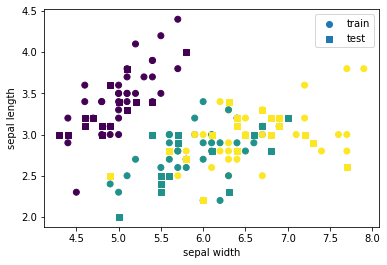

In [24]:
plt.scatter(x_train[:,0], x_train[:, 1], c=y_train, marker='o', label='train')
plt.scatter(x_test[:,0], x_test[:, 1], c=y_test, marker='s', label='test')
plt.legend()
plt.ylabel('sepal length')
plt.xlabel('sepal width')

## The KNN Class

Our python models will be implemented as classes. Two class methods that we usually need are fit and predict. The fit method performs training by fitting the data. The predict method makes prediction on the new data. In the __init__ function, we initiliaze our model which includes initializing hyper parameters.

#### Hyper-parameters
K: number of nearest neighbours

In [25]:
## Euclidean distance function
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)

class KNN:
    def __init__(self, K=1, dist_fn=euclidean):
        self.K = K
        self.dist_fn = dist_fn
        return
    
    def fit(self, x_train, y_train):
        '''KNN is a lazy learner so store the training data as it is.'''
        self.x = x_train
        self.y = y_train
        self.C = np.max(y_train) + 1
        return self
    
    def predict(self, x_test):
        '''Make a prediction using the stored train data and the input test data'''
        
        num_test = x_test.shape[0]
        
        # N1: number of train instances
        # N2: number of test instances
        # D: number of features
        #
        # x_train --> (N1,D)
        # x_test --> (N2,D)
        #
        # For each test point, we want to know the distance between the test point 
        # and each train point.
        # Result matrix shape: (N2,N1)
        #
        # To get (N2,N1,D) from (N1,D) and (N2,D), we use broadcasting. 
        # Inputs: (1,N1,D) and (N2,1,D) --> Stretched to (N2,N1,D) during arithmetic operations
        # Reshaped into (N2,N1) when computing the distances
        
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])
        
        # find knns for each test point. Store the indices of the nearest neighbors.
        # the i-th row of knns store the indices of the k nearest neighbours of the ith sample
        knns = np.zeros((num_test, self.K), dtype=int)
        
        # probability distribution for y classes
        y_prob = np.zeros((num_test, self.C))
        
        # find the K nearest neighbors for each test point
        # iterate through all test points
        # sort the distances for every test point and take the K smallest
        for i in range(num_test):
            # np.argsort returns the INDICES
            knns[i,:] = np.argsort(distances[i])[:self.K]
            # check in the training data the number of occurences of each class in the 
            # knns of the test point
            y_prob[i,:] = np.bincount(self.y[knns[i,:]], minlength=self.C)
            
        # to get the probability, divide by number of neighbours
        y_prob /= self.K
        return y_prob, knns

## Fit the Model and Predict

For KNN, no learning occurs in training time

In [26]:
model = KNN(K=3)
y_prob, knns = model.fit(x_train, y_train).predict(x_test)
print('knns shape: ', knns.shape)
print('y_prob shape: ', y_prob.shape)

Knns shape:  (50, 3)
y_prob shape:  (50, 3)


In [27]:
# we want to get the y prediction with the highest probability
#np.argmax returns the indices with the highest value on an axis
y_pred = np.argmax(y_prob, axis=-1)

In [28]:
# calculate accuracy by comparing with the y_test values

# passing a boolean array to np.sum will count and return the number of True elements
accuracy = np.sum(y_pred == y_test)/y_test.shape[0]

print(f'accuracy is {accuracy*100:.1f}.')


# correct predictions
correct = y_pred == y_test
incorrect = np.logical_not(correct)

accuracy is 38.0.


## Visualization of Correct/Incorrect Predictions

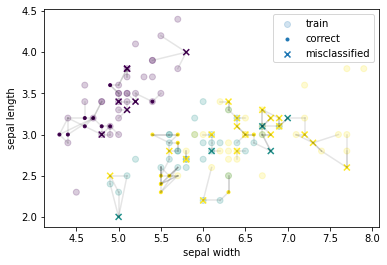

In [29]:
#visualization of the points
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', alpha=.2, label='train')
plt.scatter(x_test[correct,0], x_test[correct,1], marker='.', c=y_pred[correct], label='correct')
plt.scatter(x_test[incorrect,0], x_test[incorrect,1], marker='x', c=y_test[incorrect], label='misclassified')

#connect each node to k-nearest neighbours in the training set
for i in range(x_test.shape[0]):
    for k in range(model.K):
        hor = x_test[i,0], x_train[knns[i,k],0]
        ver = x_test[i,1], x_train[knns[i,k],1]
        plt.plot(hor, ver, 'k-', alpha=.1)
        
plt.legend()
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.show()

## Decision Boundaries

To draw the decision boundary we classify all the points on a 2D grid. The meshgrid function creates all the points on the grid by taking discretizations of horizontal and vertical axes.

In [ ]:
#we can make the grid finer by increasing the number of samples from 200 to higher value
x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)

#to features values as a mesh  
x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

for k in range(1,4):
  model = KNN(K=k)

  y_train_prob = np.zeros((y_train.shape[0], C))
  y_train_prob[np.arange(y_train.shape[0]), y_train] = 1

  #to get class probability of all the points in the 2D grid
  y_prob_all, _ = model.fit(x_train, y_train).predict(x_all)

  y_pred_all = np.zeros_like(y_prob_all)
  y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1

  plt.scatter(x_train[:,0], x_train[:,1], c=y_train_prob, marker='o', alpha=1)
  plt.scatter(x_all[:,0], x_all[:,1], c=y_pred_all, marker='.', alpha=0.01)
  plt.ylabel('sepal length')
  plt.xlabel('sepal width')
  plt.show()

We can also plot class probabilities (different values of probabilities take different colors)

In [ ]:
plt.scatter(x_train[:,0], x_train[:,1], c=y_train_prob, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=y_prob_all, marker='.', alpha=.01)
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.show()

## The Effect of Noise and Feature Scaling

Nearest neighbours are HIGHLY affected by the existence of noisy or irrelevant features.

In the following example, we add noise to see the effect ont the accuracy of our prediction

In [ ]:
noise_scale = [.01, .1, 1, 10, 100, 1000]

#generate random noise
noise = np.random.randn(x.shape[0],1)
results = []

# One test for each noise scale
for s in noise_scale:
    #add noise the noise column as an extra feature
    # according to the random noises factor we generated for the inputs
    x_n = np.column_stack((x, noise*s))
    results.append([])
    #repeat the experiment 100 times with different train and test split
    for r in range(100):
        #data processing and train-test split
        inds = np.random.permutation(N)
        x_train, y_train = x_n[inds[:100]], y[inds[:100]]
        x_test, y_test = x_n[inds[100:]], y[inds[100:]]
        #define model
        model = KNN(K=3)
        #prediction
        y_prob, _ = model.fit(x_train, y_train).predict(x_test)
        y_pred = np.argmax(y_prob,1)
        accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
        results[-1].append(accuracy)
results = np.array(results)
plt.errorbar(noise_scale, results.mean(1), results.std(1))
plt.xscale('log')
plt.xlabel("scale of the noisy feature")
plt.ylabel("accuracy")
plt.show()